# Deep Convolutional Generative Adversarial Network - Anime Faces

### Setup

In [1]:
# To generate GIFs
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy


Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython import display
import time
from IPython.display import Image
import os
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio
import math
import glob
import PIL
import PIL.Image

In [3]:
import tensorflow as tf
from keras import layers, backend
import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2022-08-27 15:07:06.939665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2022-08-27 15:07:06.940004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:07:07.087894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:07:07.088103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:07:07.088249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:07:07.088389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [5]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        #ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        crop_to_aspect_ratio = True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    # Remap [0,255] -> [-1, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0),
                                              AUTOTUNE)

    return normalized_ds


In [6]:

latent_space_size = 128

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (128, 128)
EPOCHS = 12

data_directory_path = "data-gan/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE)

#
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_images = train_images.with_options(options)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-gan: Found 92108 files
Found 92108 files belonging to 1 classes.
Number of batches 720 of 128 elements


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size.

In [7]:
def make_generator_model(input_shape):
    model = tf.keras.Sequential()

    init = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - 4, 0)

    # foundation for 4x4 image
    n_nodes = 1024 * 4 * 4
    model.add(layers.Dense(
        n_nodes, kernel_initializer=init, input_dim=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # Note: None is the batch size
    assert model.output_shape == (None, 4, 4, 1024)

    # upsample to 8x8
    model.add(layers.Conv2DTranspose(filters=1024, kernel_size=(4, 4), strides=(2, 2),
                                     use_bias=False, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    for i in range(0, num_layers + 1):
        filter_size = int(512 / (2 ** i))
        image_size = (16 * (2 ** i), 16 * (2 ** i))

        filter_size  = min(1024, filter_size)

        model.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same',
                                         kernel_initializer=init))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        assert model.output_shape == (
            None, image_size[0], image_size[1], filter_size)

    # output layer
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(
        1, 1), padding='same', kernel_initializer=init))
    model.add(layers.Activation('tanh'))
    # TODO add color channel
    assert model.output_shape == (None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    return model

Use the (as yet untrained) generator to create an image.

### The Discriminator

The discriminator is a CNN-based image classifier.

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    n_layers = max(int(math.log2(IMAGE_SIZE[1])) - 3, 0)

    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), use_bias=False, padding='same',
                            input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    for i in range(0, n_layers):
        filter_size = 64 * (2 ** i)
        kernel_size = (5, 5)

        filter_size  = min(1024, filter_size)
        
        model.add(layers.Conv2D(filter_size, kernel_size=kernel_size,
                                strides=(2, 2), use_bias=False, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, kernel_size=4, strides=(
        2, 2), padding='valid', use_bias=False))
    model.add(layers.Flatten())
    model.add(layers.Activation('sigmoid'))

    return model


Example of using the discriminator for determine if a image is real. However, since either model are trained, the result will not be useful.

In [9]:
latent_space_c = (latent_space_size)

with strategy.scope():
    global generator, discriminator
    generator = make_generator_model(latent_space_c)
    discriminator = make_discriminator_model()
    


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Generator Model

2022-08-27 15:07:57.721805: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-27 15:07:58.059453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-08-27 15:08:00.027602: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor([[0.50011384]], shape=(1, 1), dtype=float32)


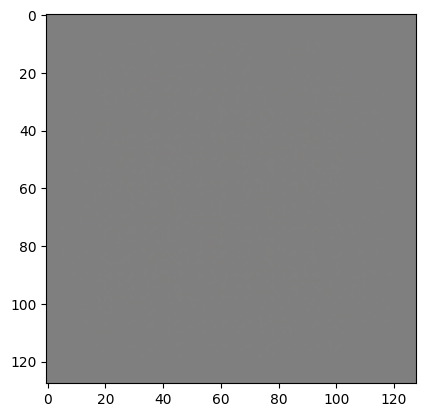

In [10]:
noise = tf.random.normal([1, latent_space_size])

generated_image = generator(noise, training=False)

# Convert image from [-1,1] to [0,1]
rgb = (generated_image[0, :, :, 0:3] + 1.0) / 2.0

plt.imshow(asarray(rgb))

decision = discriminator(generated_image)
print(decision)

## Model Layer Composition

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 1024)       16777216  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 1024)       4

## Discriminator Model

In [12]:
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51200     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)       

## Display Methods

In [13]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


def generate_and_save_images(model, epoch, latent_space):
    fig = generate_grid_image(model=model, latent_space=latent_space)
    fig.savefig('image_at_epoch_{:04d}.png'.format(epoch), transparent=False)
    plt.show()


In [14]:
# Generate a big image.
def generateBigBridImage(model, grid_size, latent_space=None):
    width, height = grid_size

    if latent_space == None:
        latent_space = tf.random.normal([width * height, latent_space_size])

    fig = plt.figure(figsize=(width * 2, height * 2))
    for i, latent in enumerate(latent_space):

        generated_images = model(tf.reshape(latent, [1, latent_space_c]) , training=False)
        plt.subplot(height, width, i+1,)

        plt.imshow(((generated_images[0, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()
    return fig


## Show the neuron network layers
When initialize the generator model, the output is a completely just noise.

In [15]:
def get_layer_outputs(model, layer_name, input_data):
    layer_output=model.get_layer(layer_name).output

    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

    intermediate_prediction=intermediate_model(input_data, training=False)
    return intermediate_prediction

def generate_each_layer(model, latent_space, grid_size):
    inp = model.input                                           # input placeholder
    
    # Testing
    test = np.random.random(latent_space.shape)[np.newaxis, ...]
    for layer in generator.layers:
        
        if 'conv2d' in layer.name:
            layer_outs = get_layer_outputs(generator, layer.name, latent_space)

            #
            width, height = grid_size
            nr_filters = layer_outs.shape[3]
            width = layer_outs.shape[1]
            height = layer_outs.shape[2]
            nr_images = layer_outs.shape[0]

            square = int(math.sqrt(nr_filters))

            #
            fig = plt.figure(figsize=(width * 2, height * 2))
            plt.title(layer.name)

            for i in range(nr_images):
                for k in range(0, nr_filters):
                    if k < square * square:

                        plt.subplot(square, square, k+1)

                        plt.imshow(((layer_outs[i, :, :, k] + 1.0) / 2.0), aspect='auto')
                        plt.axis("off")
            plt.subplots_adjust(wspace=0.005, hspace=0.005)
            plt.show()


In [16]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show(block=False)


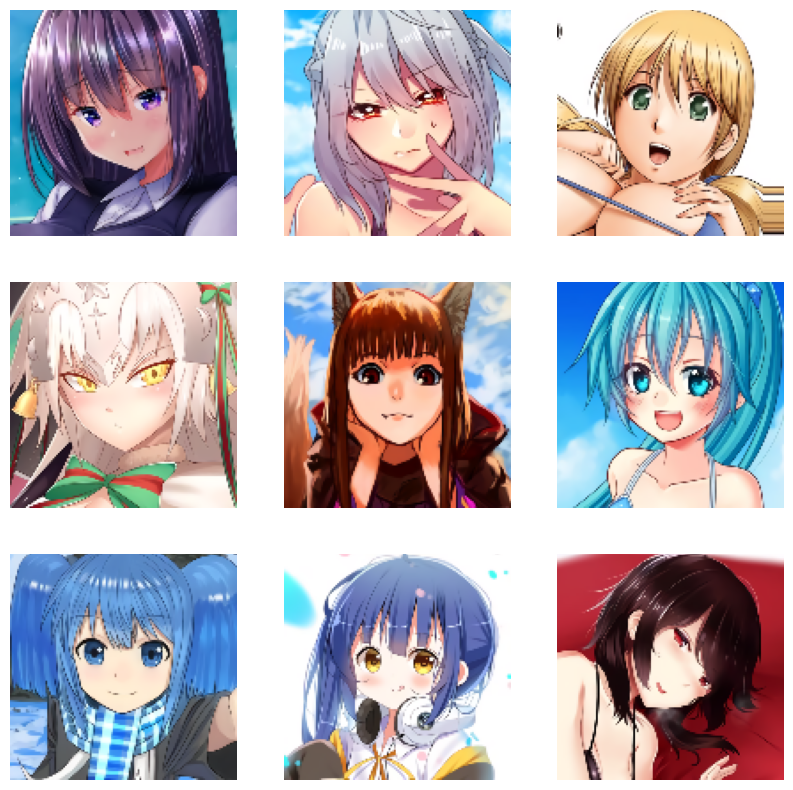

In [17]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF.
seed = tf.random.normal([num_examples_to_generate, latent_space_size])

plt.figure(figsize=(10, 10))
for images in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((images[i].numpy() + 1.0) / 2.0)
        plt.axis("off")
plt.show()

## Train Model

In [18]:
generator_model_filepath = "dcgan-anime-generator.h5"

grid_size = (16, 9)

with strategy.scope():
    latent_space_size = 128
    fixed_latent_space_noise = tf.random.normal([16 * 9, latent_space_size])

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

    cross_entropy = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output, smooth=0.11):

        # label for real image is (1-smooth)
        real_loss = cross_entropy(tf.ones_like(
            real_output)*(1-smooth), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss

        return total_loss

    @tf.function
    def step_fn(data):
        assert tf.distribute.get_replica_context() is not None
        batch_size = tf.shape(data)[0]

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size, latent_space_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            # generate image using generator
            generated_image = generator(seed, training=True)

            # discriminator's prediction for real image
            real_output = discriminator(data, training=True)

            # discriminator's estimate for fake image
            fake_output = discriminator(
                generated_image, training=True)

            # compute loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(
                gen_loss, generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(
                disc_loss, discriminator.trainable_variables)

            # optimize discriminator after generator
            generator_optimizer.apply_gradients(
                zip(generator_grad, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(
                zip(discriminator_grad, discriminator.trainable_variables))

            #train_accuracy.update_state(labels, predictions)
        return {
            "generator_loss": gen_loss,
            "discriminator_loss": disc_loss
        }

    # @tf.function

    def distributed_train_step(data):
        per_replica_losses = strategy.run(step_fn, args=(data,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                               axis=None)



    generator_model_filepath = "dcgan-anime-generator.h5"
    if os.path.exists(generator_model_filepath):
        generator = tf.keras.models.load_model(generator_model_filepath)
    else:
        generator = make_generator_model(latent_space_c)

    if os.path.exists("dcgan-anime-discriminator.h5"):
        discriminator = tf.keras.models.load_model("dcgan-anime-discriminator.h5")
    else:
        discriminator = make_discriminator_model()

    generator_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5)

    for epoch in range(EPOCHS):

        total_loss = 0.0
        train_loss = 0

        for batch_index, images in enumerate(train_images):
            per_replica_losses = strategy.run(step_fn, args=(images,))
            total_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                                         axis=None)

            print("Epoch {0} Batch: {1}/{2}".format(epoch+1, batch_index,
                  len(train_images)), end='\r') #gen-loss: {3} disc-los: {4} total_loss["generator_loss"], total_loss["discriminator_loss"]
            if batch_index % 100 == 0:

                big_fig = generateBigBridImage(generator, grid_size, fixed_latent_space_noise)
                big_fig.savefig('big_image_at_epoch_{0}_batch{1}.png'.format(
                    epoch + 1, batch_index), transparent=None)
                generator.save(generator_model_filepath)
                discriminator.save("dcgan-anime-discriminator.h5")

        generator.save(generator_model_filepath)
        discriminator.save("dcgan-anime-discriminator.h5")

        big_fig = generateBigBridImage(generator, grid_size, fixed_latent_space_noise)
        big_fig.savefig('big_image_at_epoch_{:04d}.png'.format(
            epoch + 1), transparent=None)

        train_accuracy.reset_states()


INFO:tensorflow:batch_all_reduce: 21 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 21 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1


2022-08-27 15:08:26.032027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


INFO:tensorflow:batch_all_reduce: 21 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1


# Final Result

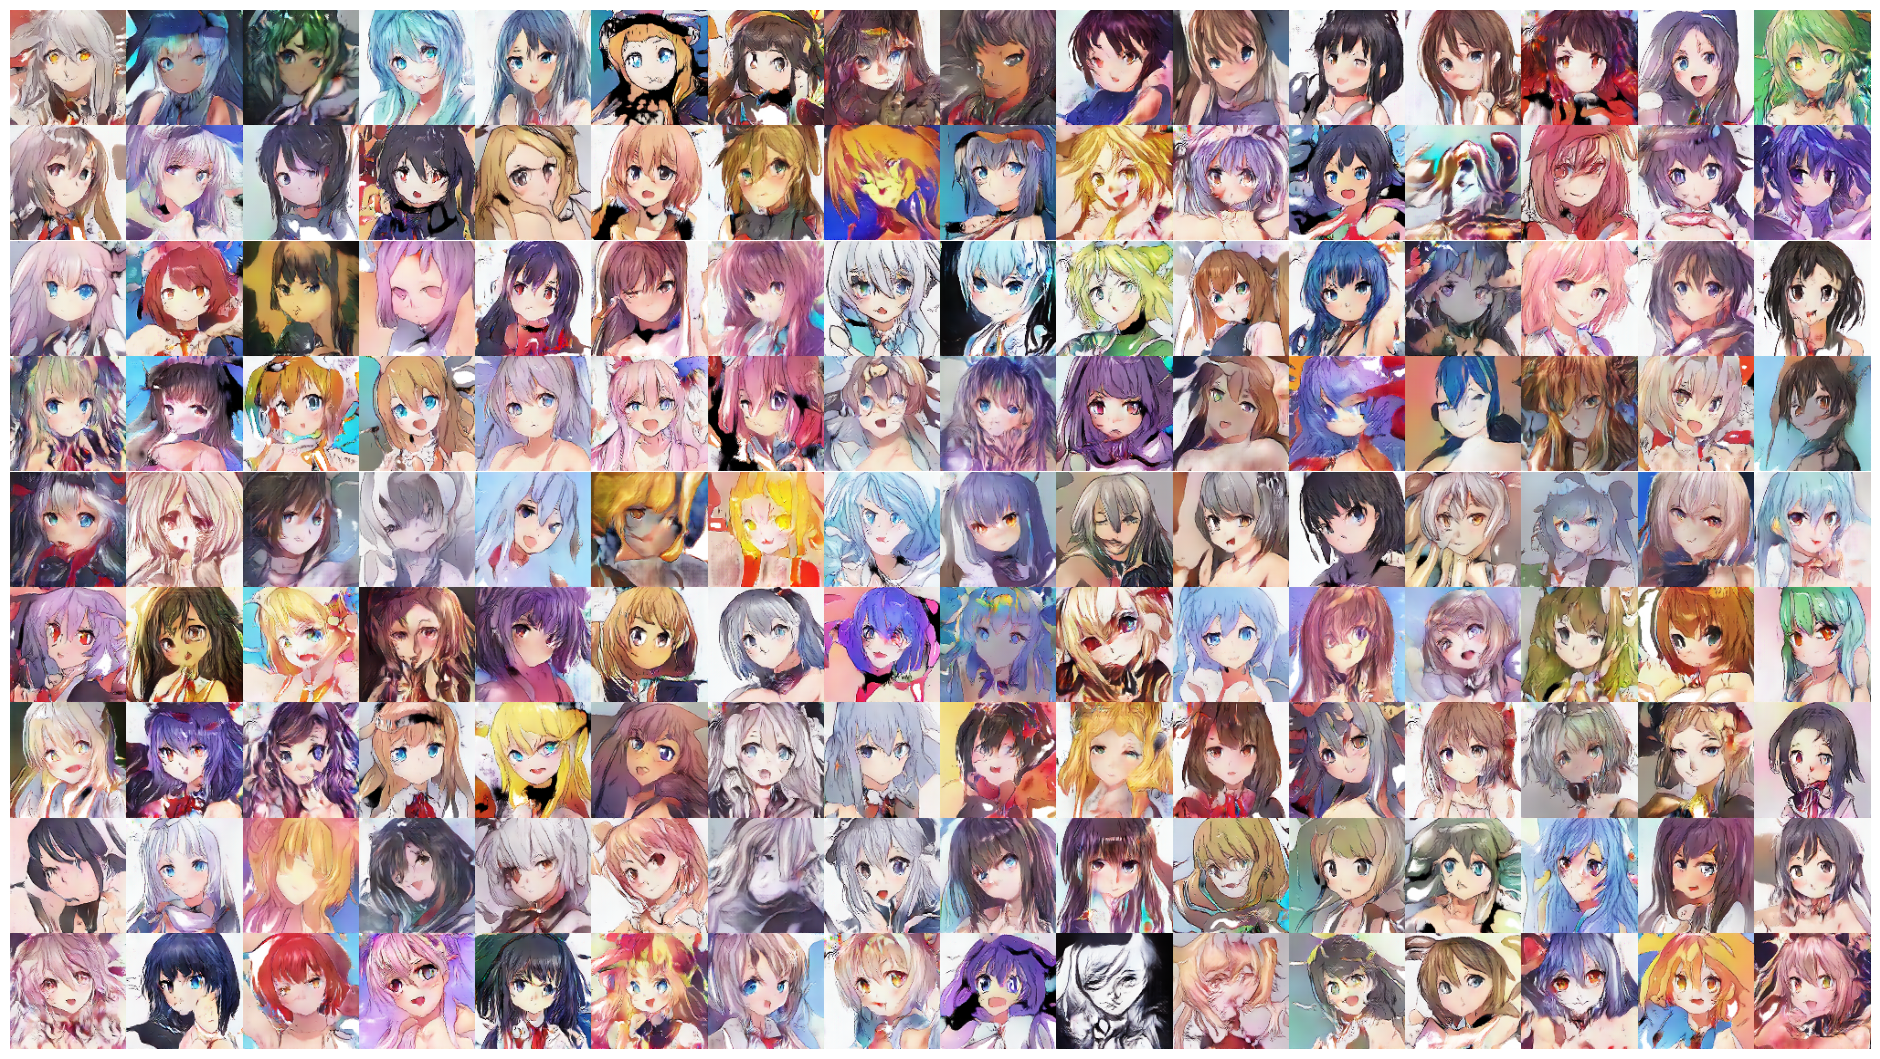

In [19]:
width, height = (16,9)
latent_space = tf.random.normal([width * height, latent_space_size])
generated_images = generator(latent_space, training=False)

fig = plt.figure(figsize=(width * 1.5, height * 1.5))
for i in range(generated_images.shape[0]):
    plt.subplot(height, width, i+1,)

    plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


## Save Final Models

In [20]:
generator_model_filepath = "dcgan-anime-generator.h5"
generator.save(generator_model_filepath)
discriminator.save("dcgan-anime-discriminator.h5")


## Load Model and Generator Results

In [21]:
generator_model_filepath = "dcgan-anime-generator.h5"
generator = tf.keras.models.load_model(generator_model_filepath)


## Show each layer of the generator model
This allows to a get an idea of what how the neuron see and how each layer becomes more and more detailed.

In [22]:
grid_size = (4, 4)
noise__ = tf.random.normal([16, latent_space_size])
generate_each_layer(generator, noise__, grid_size)

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'anime-dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


Image(url=anim_file)


## Generate Transition Image

By adjusting between two points within the latent space and interpolated of number of frames.

In [19]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [20]:
def generate_transition(model, gris_size):
      nr_elemenets = 4
      seeds = np.random.randint(10000, size=2)
      zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
            for s in seeds]
      
      all_latents = interpolate(zs, nr_elemenets)

      generated_images = model(latent_space, training=False)

      fig = plt.figure(figsize=(width * 2, height * 2))
      for i in range(generated_images.shape[0]):
            plt.subplot(height, width, i+1,)

            plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
            plt.axis("off")
      plt.subplots_adjust(wspace=0, hspace=0)
      plt.close()



In [21]:
import scipy
import moviepy.editor


In [22]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = duration_sec * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 9

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    #
    fig = generate_grid_image(generator, latents, (5, 5), (3, 3))

    #
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file transition_grid_4491.gif with imageio.


In [23]:
Image(url=gif_filepath)


## Generate Single Image Transition

In [24]:
duration_sec = 20
num_frames = duration_sec * fps
seeds = np.random.randint(10000, size=20)

zs = [tf.random.normal([1, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, int(num_frames / 20))

def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    #
    data = (generator(latents, training=False) + 1) * 0.5

    #
    #fig.canvas.draw()
    data = np.asarray(data[0]).reshape((128,128,3))*255
    #data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('transition_long_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)

MoviePy - Building file transition_long_grid_3652.gif with imageio.


t:  95%|█████████▍| 284/300 [00:13<00:00, 21.29it/s, now=None]

IndexError: list index out of range